###                                                                                         Name: Sharon Laurance Muthipeedika 
###                                                                                         Matriculation No: 312486

### Distributed Computing with Apache Spark

## Exercise 1: Apache Spark Basics
### Part a) Basic Operations on Resilient Distributed Dataset (RDD)

In [1]:
###Import required Libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, when, isnull, sum, count, lit, avg, stddev,col
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import findspark
findspark.init()
#Create Spark Session
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()
sparkContext=spark.sparkContext

### Create two RDD objects of a, b and do the following tasks. Words should be remained in the results of join operations.


In [2]:
a = ["spark", "rdd", "python", "context", "create", "class"]
b = ["operation", "apache", "scala", "lambda","parallel","partition"]

In [3]:
rdd_a=sparkContext.parallelize(a)
rdd_b=sparkContext.parallelize(b)

In [4]:
rdd_a.count()

6

### 1. Perform rightOuterJoin and fullOuterJoin operations between a and b. Briefly explain your solution.

#### Right Outer Join selects the common words from both the lists and all the words from the list written on the right which is rdd_b. Therefore the result is 6 words.

In [5]:
rdd_a.map(lambda x:(x,1)).rightOuterJoin(rdd_b.map(lambda x:(x,1))).collect()

[('parallel', (None, 1)),
 ('lambda', (None, 1)),
 ('scala', (None, 1)),
 ('operation', (None, 1)),
 ('apache', (None, 1)),
 ('partition', (None, 1))]

#### FULL OUTER JOIN selects the common rows as well as all the remaining rows from both of the tables. Therefore there are 12 words. I tried doing only fullOuterJoin but it was giving letters instead of words. So, map is used here.

In [6]:
rdd_a.map(lambda x:(x,1)).fullOuterJoin(rdd_b.map(lambda x:(x,1))).collect()

[('python', (1, None)),
 ('spark', (1, None)),
 ('context', (1, None)),
 ('create', (1, None)),
 ('parallel', (None, 1)),
 ('lambda', (None, 1)),
 ('class', (1, None)),
 ('rdd', (1, None)),
 ('scala', (None, 1)),
 ('operation', (None, 1)),
 ('apache', (None, 1)),
 ('partition', (None, 1))]

### 2. Using map and reduce functions to count how many times the character "s" appears in all a and b.

In [7]:
mapper = lambda x:x.count('s')
print(f"Number of times s appears in a and b: {rdd_a.map(mapper).reduce(lambda x, y: x + y)+rdd_b.map(mapper).reduce(lambda x, y: x + y)}")

number of times s appears in a and b: 4


### 3. Using aggregate function to count how many times the character "s" appears in all a and b.

In [8]:
fn1 = lambda x,y : x + y.count('s')
fn2 = lambda x,y : x+y
print(f"number of times s appears in a and b: {rdd_a.aggregate(0, fn1,fn2) + rdd_b.aggregate(0, fn1,fn2)}")

number of times s appears in a and b: 4


### Part b) Basic Operations on DataFrames

### Read the json file

In [36]:
df = spark.read.json("D:/Data Analytics/DDA LAB/Lab 9/students.json")

In [37]:
df.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|     null|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

In [38]:
df.printSchema()

root
 |-- course: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- points: long (nullable = true)
 |-- s_id: long (nullable = true)



### 1. Replace the null value(s) in column points by the mean of all points.

#### Here the fillna() function is used. So first all columns with null are replaced by zero. Then the mean is found out.

In [39]:
from pyspark.sql.functions import mean

df_mean=df.fillna(value=0, subset=['points']).select(mean(df.columns[4]).alias('avg')).collect()
avg=df_mean[0]['avg']
df=df.fillna(value=avg,subset=["points"])
df.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|     null|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

### 2. Replace the null value(s) in column dob and column last name by "unknown" and "--" respectively.

In [40]:
df=df.fillna(value="unknown",subset=["dob"])
df=df.fillna(value="--",subset=["last_name"])
df.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|       --|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

### 3. In the dob column, there exist several formats of dates, e.g. October 14, 1983 and 26 December 1989. Let’s convert all the dates into DD-MM-YYYY format where DD, MM and YYYY are two digits for day, two digits for months and four digits for year respectively.

In [41]:
from pyspark.sql.functions import *

#### In the convert_date function formats are taken according to spark 3.x. To accomodate this LEGACY policy is set

In [42]:
from pyspark.sql.functions import to_date 
from pyspark.sql.functions import datediff,col
# df1=df.select(to_date(df.dob, 'MMMM dd, yyyy').alias('dt'))
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
def convert_date(col, formats=("MMMM dd, yyyy", "dd MMMM yyyy")):
    return coalesce(*[to_date(col, f) for f in formats])

df = df.select("course", date_format(convert_date(df.dob),"dd-MM-yyyy").alias("new_dob"),"first_name", "last_name", "points", "s_id")
df.show()

+------------------+----------+----------+---------+------+----+
|            course|   new_dob|first_name|last_name|points|s_id|
+------------------+----------+----------+---------+------+----+
|Humanities and Art|14-10-1983|      Alan|      Joe|    10|   1|
|  Computer Science|26-09-1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|12-06-1982|     Athur|   Watson|    16|   3|
|    Graphic Design|05-04-1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|01-11-1978|      Kira| Schommer|    11|   5|
|          Business|17-02-1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|01-01-1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|13-01-1978|      John|       --|    10|   8|
|  Machine Learning|26-12-1989|    Marcus|   Carson|    15|   9|
|           Physics|30-12-1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|12-06-1975|     Holly| Schwartz|    12|  11|
|  Computer Science|02-07-1985|     April|    Black|    11|  12|
|  Computer Science|22-07

### 4. Insert a new column age and calculate the current age of all students. 

#### datediff() function is used to calculate the difference between current date and "new_dob" column

In [43]:
def calculate_age(col):
    return datediff(current_timestamp(),to_date(col,"dd-MM-yyyy"))/365

df = df.select("course", "new_dob", calculate_age("new_dob").alias("age"),"first_name", "last_name", "points", "s_id")
df.show()

+------------------+----------+------------------+----------+---------+------+----+
|            course|   new_dob|               age|first_name|last_name|points|s_id|
+------------------+----------+------------------+----------+---------+------+----+
|Humanities and Art|14-10-1983| 38.74520547945205|      Alan|      Joe|    10|   1|
|  Computer Science|26-09-1980|41.794520547945204|    Martin|  Genberg|    17|   2|
|    Graphic Design|12-06-1982|40.084931506849315|     Athur|   Watson|    16|   3|
|    Graphic Design|05-04-1987| 35.26849315068493|  Anabelle|  Sanberg|    12|   4|
|        Psychology|01-11-1978|  43.6986301369863|      Kira| Schommer|    11|   5|
|          Business|17-02-1981|              41.4| Christian|   Kiriam|    10|   6|
|  Machine Learning|01-01-1984| 38.52876712328767|   Barbara|  Ballard|    14|   7|
|     Deep Learning|13-01-1978|  44.4986301369863|      John|       --|    10|   8|
|  Machine Learning|26-12-1989| 32.53972602739726|    Marcus|   Carson|    1

In [44]:
a=df.agg({"points":"stddev"}).collect()

### 5. Let’s consider granting some points for good performed students in the class. For each student, if his point is larger than 1 standard deviation of all points, then we update his current point to 20, which is the maximum. 

#### Here one standard deviation is considered. So mean + stddev is done. The value is collected as val. It is compared with each value in the column. 
 - If the current points are greater than val, then point is updated as 20. Otherwise its kept the same.

In [45]:
df_stats = df.select((stddev("points") + mean("points")).alias('one_std_dev'))
val = df_stats.collect()[0][0]
val
df = df.withColumn("points", when(df.points > val, 20).otherwise(df.points))
df.show()

+------------------+----------+------------------+----------+---------+------+----+
|            course|   new_dob|               age|first_name|last_name|points|s_id|
+------------------+----------+------------------+----------+---------+------+----+
|Humanities and Art|14-10-1983| 38.74520547945205|      Alan|      Joe|    10|   1|
|  Computer Science|26-09-1980|41.794520547945204|    Martin|  Genberg|    20|   2|
|    Graphic Design|12-06-1982|40.084931506849315|     Athur|   Watson|    20|   3|
|    Graphic Design|05-04-1987| 35.26849315068493|  Anabelle|  Sanberg|    12|   4|
|        Psychology|01-11-1978|  43.6986301369863|      Kira| Schommer|    11|   5|
|          Business|17-02-1981|              41.4| Christian|   Kiriam|    10|   6|
|  Machine Learning|01-01-1984| 38.52876712328767|   Barbara|  Ballard|    14|   7|
|     Deep Learning|13-01-1978|  44.4986301369863|      John|       --|    10|   8|
|  Machine Learning|26-12-1989| 32.53972602739726|    Marcus|   Carson|    2

### Final Dataset Snapshot

In [46]:
df=df.fillna(value="unknown",subset=["new_dob"])
df.show()

+------------------+----------+------------------+----------+---------+------+----+
|            course|   new_dob|               age|first_name|last_name|points|s_id|
+------------------+----------+------------------+----------+---------+------+----+
|Humanities and Art|14-10-1983| 38.74520547945205|      Alan|      Joe|    10|   1|
|  Computer Science|26-09-1980|41.794520547945204|    Martin|  Genberg|    20|   2|
|    Graphic Design|12-06-1982|40.084931506849315|     Athur|   Watson|    20|   3|
|    Graphic Design|05-04-1987| 35.26849315068493|  Anabelle|  Sanberg|    12|   4|
|        Psychology|01-11-1978|  43.6986301369863|      Kira| Schommer|    11|   5|
|          Business|17-02-1981|              41.4| Christian|   Kiriam|    10|   6|
|  Machine Learning|01-01-1984| 38.52876712328767|   Barbara|  Ballard|    14|   7|
|     Deep Learning|13-01-1978|  44.4986301369863|      John|       --|    10|   8|
|  Machine Learning|26-12-1989| 32.53972602739726|    Marcus|   Carson|    2

In [19]:
df.select("points").describe().show()

+-------+-----------------+
|summary|           points|
+-------+-----------------+
|  count|               20|
|   mean|            12.35|
| stddev|4.331949846626136|
|    min|                6|
|    max|               20|
+-------+-----------------+



In [20]:
!pip install pyspark-dist-explore

### 6. Create a histogram on the new points created in the task 5.

#### Here histogram is created with 7 bins

(array([2., 2., 7., 4., 1., 0., 4.]),
 array([ 6,  8, 10, 12, 14, 16, 18, 20]),
 <BarContainer object of 7 artists>)

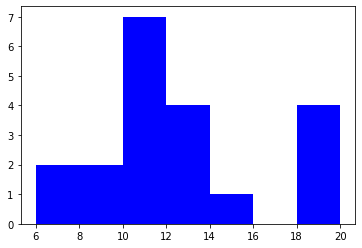

In [47]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
# df.hist('points');
fig, ax = plt.subplots()
hist(ax, df.select('points'), bins = 7, color=['blue'])

## Exercise 2: Manipulating Recommender Dataset with Apache Spark

#### While reading the file header is not given. Therefore we use the alias to give “UserID::MovieID::Tag::Timestamp” to the columns.

In [22]:
#Create Spark Session
spark = SparkSession.builder.appName('Movielens Data').getOrCreate()
sc=spark.sparkContext
##Read the tags.dat file
df = spark.read.option("delimiter", "::").csv("D:/Data Analytics/DDA LAB/Lab 9/tags.dat")
df.printSchema()
## Rename the column Names
df = df.select(col("_c0").alias("UserID"), col("_c1").alias("MovieID"), col("_c2").alias("Tag"), col("_c3").alias("Timestamp"))
df.show()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)

+------+-------+--------------------+----------+
|UserID|MovieID|                 Tag| Timestamp|
+------+-------+--------------------+----------+
|    15|   4973|          excellent!|1215184630|
|    20|   1747|            politics|1188263867|
|    20|   1747|              satire|1188263867|
|    20|   2424|     chick flick 212|1188263835|
|    20|   2424|               hanks|1188263835|
|    20|   2424|                ryan|1188263835|
|    20|   2947|              action|1188263755|
|    20|   2947|                bond|1188263756|
|    20|   3033|               spoof|1188263880|
|    20|   3033|           star wars|1188263880|
|    20|   7438|              bloody|1188263801|
|    20|   7438|             kung fu|1188263801|
|    20|   7438|           Tarantino|1188263801|
|    21|  55247|                   R|1205081506|
|    21|  55253|     

#### Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970. So, from_unixtime() function is used to convert to normal timestamp. This is a string which is then casted to timestamp.

In [23]:
#Convert timestamp to unix timestamp
df2 = df.withColumn("timestamp" ,F.from_unixtime(col("Timestamp")).cast("timestamp"))
df2.show(truncate=False)

+------+-------+--------------------+-------------------+
|UserID|MovieID|Tag                 |timestamp          |
+------+-------+--------------------+-------------------+
|15    |4973   |excellent!          |2008-07-04 17:17:10|
|20    |1747   |politics            |2007-08-28 03:17:47|
|20    |1747   |satire              |2007-08-28 03:17:47|
|20    |2424   |chick flick 212     |2007-08-28 03:17:15|
|20    |2424   |hanks               |2007-08-28 03:17:15|
|20    |2424   |ryan                |2007-08-28 03:17:15|
|20    |2947   |action              |2007-08-28 03:15:55|
|20    |2947   |bond                |2007-08-28 03:15:56|
|20    |3033   |spoof               |2007-08-28 03:18:00|
|20    |3033   |star wars           |2007-08-28 03:18:00|
|20    |7438   |bloody              |2007-08-28 03:16:41|
|20    |7438   |kung fu             |2007-08-28 03:16:41|
|20    |7438   |Tarantino           |2007-08-28 03:16:41|
|21    |55247  |R                   |2008-03-09 17:51:46|
|21    |55253 

### 1. A tagging session for a user can be defined as the duration in which he/she generated tagging activities. Typically, an inactive duration of 30 mins is considered as a termination of the tagging session. Your task is to separate out tagging sessions for each user.

### To perform an operation on a group first, we need to partition the data using Window.partitionBy() , and for row number we need to additionally order by on partition data using orderBy clause. For lag(Column, offset) returns the value that is "offset" (i.e. 1) rows before the current row, and "null" if there is less than 1 row before the current row.

In [24]:
window  = Window.partitionBy("UserID").orderBy("timestamp")

## Calculating lag column here
df3=df2.withColumn("lag",lag("timestamp",1).over(window))

df4=df3.withColumn("diff_in_sec",col("timestamp").cast("long")-col("lag").cast("long"))

df5=df4.withColumn("session_complete",when(col("diff_in_sec")>30*60,1).otherwise(0))
df5.show()

+------+-------+----------------+-------------------+-------------------+-----------+----------------+
|UserID|MovieID|             Tag|          timestamp|                lag|diff_in_sec|session_complete|
+------+-------+----------------+-------------------+-------------------+-----------+----------------+
|  1000|    277|children's story|2007-08-31 06:05:11|               null|       null|               0|
|  1000|   1994|    sci-fi. dark|2007-08-31 06:05:36|2007-08-31 06:05:11|         25|               0|
|  1000|   5377|         romance|2007-08-31 06:05:50|2007-08-31 06:05:36|         14|               0|
|  1000|   7147|    family bonds|2007-08-31 06:06:01|2007-08-31 06:05:50|         11|               0|
|  1000|    362|animated classic|2007-08-31 06:06:11|2007-08-31 06:06:01|         10|               0|
|  1000|    276|          family|2007-08-31 06:07:15|2007-08-31 06:06:11|         64|               0|
| 10003|  42013|        Passable|2006-06-16 06:33:55|               null|

#### Here for a user a session stars with zero
#### If the difference is greater than 30 min(i.e. 1800 sec) then other session is created. Otherwise the same session continues. 
#### For eg. for UserID 1000 diff_in_sec is always less than 1800 sec so same session continues.

In [26]:
w = Window.partitionBy(df5.UserID).orderBy(df5.timestamp).rowsBetween(Window.unboundedPreceding, Window.currentRow)
df6 = df5.withColumn('session_id', F.sum(col("session_complete")).over(w))

df6.show(20)

+------+-------+----------------+-------------------+-------------------+-----------+----------------+----------+
|UserID|MovieID|             Tag|          timestamp|                lag|diff_in_sec|session_complete|session_id|
+------+-------+----------------+-------------------+-------------------+-----------+----------------+----------+
|  1000|    277|children's story|2007-08-31 06:05:11|               null|       null|               0|         0|
|  1000|   1994|    sci-fi. dark|2007-08-31 06:05:36|2007-08-31 06:05:11|         25|               0|         0|
|  1000|   5377|         romance|2007-08-31 06:05:50|2007-08-31 06:05:36|         14|               0|         0|
|  1000|   7147|    family bonds|2007-08-31 06:06:01|2007-08-31 06:05:50|         11|               0|         0|
|  1000|    362|animated classic|2007-08-31 06:06:11|2007-08-31 06:06:01|         10|               0|         0|
|  1000|    276|          family|2007-08-31 06:07:15|2007-08-31 06:06:11|         64|   

### 2. Once you have all the tagging sessions for each user, calculate the frequency of tagging for each user session.


### - Here grouping is done by UserID and session Id, this gives unique number of sessions for each user.

In [27]:
# from pyspark.sql import functions as F
tagging_df=df6.groupby("UserId","session_id").agg(F.count("session_id").alias("frequency"))
tagging_df.show()

+------+----------+---------+
|UserId|session_id|frequency|
+------+----------+---------+
|  1000|         0|        6|
| 10003|         0|        1|
| 10003|         1|       18|
| 10003|         2|       38|
| 10020|         0|        2|
| 10025|         0|        1|
| 10032|         0|       39|
| 10032|         1|        1|
| 10032|         2|        1|
| 10032|         3|        1|
| 10032|         4|        4|
| 10032|         5|        1|
| 10032|         6|        1|
| 10032|         7|        4|
| 10032|         8|        1|
| 10032|         9|        1|
| 10032|        10|        1|
| 10032|        11|        1|
| 10051|         0|        1|
| 10058|         0|       35|
+------+----------+---------+
only showing top 20 rows



### 3. Find a mean and standard deviation of the tagging frequency of each user.


### - Here grouping by "UserID" is done and Mean and Standard Deviation of each user is found out.

In [28]:
tagging_user_mean = tagging_df.groupBy(['UserId']).agg(F.mean('Frequency').alias('Mean'))
tagging_user_std=tagging_df.groupBy(['UserId']).agg(F.stddev('Frequency').alias('Std_Dev'))
tagging_user_mean.show()
tagging_user_std.show()

+------+------------------+
|UserId|              Mean|
+------+------------------+
|  1000|               6.0|
| 10003|              19.0|
| 10020|               2.0|
| 10025|               1.0|
| 10032| 4.666666666666667|
| 10051|               1.0|
| 10058|25.333333333333332|
| 10059|               2.5|
| 10064|               1.0|
| 10084|              3.75|
| 10094|               2.0|
|  1010|               4.0|
| 10117|               1.5|
| 10125|              21.0|
| 10132|            1.5625|
| 10154|               8.0|
| 10167|               1.0|
|  1017|               7.0|
| 10181|              11.0|
| 10191|2.6666666666666665|
+------+------------------+
only showing top 20 rows

+------+------------------+
|UserId|           Std_Dev|
+------+------------------+
|  1000|              null|
| 10003|18.520259177452136|
| 10020|              null|
| 10025|              null|
| 10032|10.873933246182093|
| 10051|              null|
| 10058|15.044378795195676|
| 10059|0.707106781186

### 4. Find a mean and standard deviation of the tagging frequency for across users.

In [35]:
std_across_users=tagging_df.agg({'frequency':'stddev'})
mean_across_users=tagging_df.agg({'frequency':'mean'})

std=std_across_users.collect()[0][0]
mean=mean_across_users.collect()[0][0]

print("Standard Deviation across all users is",std)
print("Mean across all users is",mean)

Standard Deviation across all users is 22.264293050265017
Mean across all users is 7.300084014358817


### 5. Provide the list of users with a mean tagging frequency within the two standard deviation from the mean frequency of all users.


### Here mean tagging frequency dataframe created in Question 3 is used. For each user is the current mean is less than two standard deviations from mean of all users which is calculated in Question 4. Rows are filtered based on this condition

In [30]:
df_5=tagging_user_mean.filter(tagging_user_mean.Mean < 2 * std + mean)
df_5.show()

+------+------------------+
|UserId|              Mean|
+------+------------------+
|  1000|               6.0|
| 10003|              19.0|
| 10020|               2.0|
| 10025|               1.0|
| 10032| 4.666666666666667|
| 10051|               1.0|
| 10058|25.333333333333332|
| 10059|               2.5|
| 10064|               1.0|
| 10084|              3.75|
| 10094|               2.0|
|  1010|               4.0|
| 10117|               1.5|
| 10125|              21.0|
| 10132|            1.5625|
| 10154|               8.0|
| 10167|               1.0|
|  1017|               7.0|
| 10181|              11.0|
| 10191|2.6666666666666665|
+------+------------------+
only showing top 20 rows



In [31]:
df_5.count()

3962

#### References:
 - https://netflixsub.com/how-to-replace-null-values-with-mean-in-pyspark-dataframe/#:~:text=Alternatively%2C%20if%20there%20are%20null,null%20with%20such%20mean%20taken.
 - https://copypaste.guru/WhereIsMyPythonModule/how-to-fix-modulenotfounderror-no-module-named-pyspark-dist-explore
 - https://stackoverflow.com/questions/39154325/pyspark-show-histogram-of-a-data-frame-column
 - https://sparkbyexamples.com/pyspark/pyspark-aggregate-functions/
 - https://sparkbyexamples.com/pyspark/pyspark-timestamp-difference-seconds-minutes-hours/
 - https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.Window.rowsBetween.html